In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
# Download Train Data
train = datasets.MNIST(
    './data', 
    train=True, 
    download=True, 
    transform=train_transforms
    
    )

# Download Test Data
test = datasets.MNIST(
    './data',
    train=False, 
    download=True, 
    transform=test_transforms
    )

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),  # Input 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        

        # CONVOLUTION BLOCK 2
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 12x12 output 10x10 RF : 6x6
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 10x10 output 8x8 RF : 10x10
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 8x8 output 6x6 RF : 14x14
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # Input 6x6 output 6x6 RF : 18x18
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value))

        self.conv7 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)  # Input 6x6 output 6x6 RF : 18x18


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool2d(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [ ]:
from tqdm import tqdm
actuals = []
predictions = []
wrong_images=[]
wrong_label=[]
correct_label=[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    lambda_l1 = 0.001
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        l1 = 0
        for p in model.parameters():
          l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1 * l1
        loss.backward()
        optimizer.step()
        scheduler.step()
        processed += len(data)
        pbar.set_description(desc= f'Epoch{epoch} : Loss={loss.item()}  Accuracy={100*correct/processed:0.2f} Batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.00*correct/len(train_loader.dataset)
    return train_acc, train_loss

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            if epoch == 20:
                actuals.extend(target.view_as(pred))
                predictions.extend(pred)
                wrong_pred = pred.eq(target.view_as(pred)) == False
                wrong_images.append(data[wrong_pred])
                wrong_label.append(pred[wrong_pred])
                correct_label.append(target.view_as(pred)[wrong_pred]) 

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = 100.00 * correct / len(test_loader.dataset)
    return test_acc, test_loss

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7)

scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(1, 21):
    train_acc, train_loss = train(model, device, train_loader, optimizer, epoch)
    test_acc, test_loss = test(model, device, test_loader, epoch)

    train_accuracy_values.append(train_acc)
    train_loss_values.append(train_loss)

    test_accuracy_values.append(test_acc)
    test_loss_values.append(test_loss)

Epoch1 : Loss=0.9346206188201904  Accuracy=65.21 Batch_id=468: 100%|██████████| 469/469 [00:56<00:00,  8.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2458, Accuracy: 9528/10000 (95.28%)



Epoch2 : Loss=0.6881731748580933  Accuracy=93.04 Batch_id=468: 100%|██████████| 469/469 [00:56<00:00,  8.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9788/10000 (97.88%)



Epoch3 : Loss=0.538316547870636  Accuracy=95.29 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9834/10000 (98.34%)



Epoch4 : Loss=0.5256069898605347  Accuracy=95.55 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9854/10000 (98.54%)



Epoch5 : Loss=0.40643420815467834  Accuracy=96.08 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9847/10000 (98.47%)



Epoch6 : Loss=0.4318249225616455  Accuracy=95.90 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9888/10000 (98.88%)



Epoch7 : Loss=0.39416760206222534  Accuracy=96.16 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9822/10000 (98.22%)



Epoch8 : Loss=0.4014543294906616  Accuracy=96.18 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9816/10000 (98.16%)



Epoch9 : Loss=0.3733268976211548  Accuracy=96.32 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9842/10000 (98.42%)



Epoch10 : Loss=0.4887491762638092  Accuracy=96.17 Batch_id=468: 100%|██████████| 469/469 [00:56<00:00,  8.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9840/10000 (98.40%)



Epoch11 : Loss=0.5049189329147339  Accuracy=96.30 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9811/10000 (98.11%)



Epoch12 : Loss=0.3698107898235321  Accuracy=96.49 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9876/10000 (98.76%)



Epoch13 : Loss=0.3690878450870514  Accuracy=96.36 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9894/10000 (98.94%)



Epoch14 : Loss=0.2776290774345398  Accuracy=96.54 Batch_id=468: 100%|██████████| 469/469 [00:56<00:00,  8.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)



Epoch15 : Loss=0.35214102268218994  Accuracy=96.75 Batch_id=468: 100%|██████████| 469/469 [00:56<00:00,  8.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9919/10000 (99.19%)



Epoch16 : Loss=0.3055932819843292  Accuracy=97.00 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9841/10000 (98.41%)



Epoch17 : Loss=0.33312249183654785  Accuracy=97.30 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9894/10000 (98.94%)



Epoch18 : Loss=0.3067667782306671  Accuracy=97.48 Batch_id=468: 100%|██████████| 469/469 [00:56<00:00,  8.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)



Epoch19 : Loss=0.21976013481616974  Accuracy=97.93 Batch_id=468: 100%|██████████| 469/469 [00:57<00:00,  8.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)



Epoch20 : Loss=0.22035425901412964  Accuracy=98.09 Batch_id=468: 100%|██████████| 469/469 [00:56<00:00,  8.25it/s]



Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)



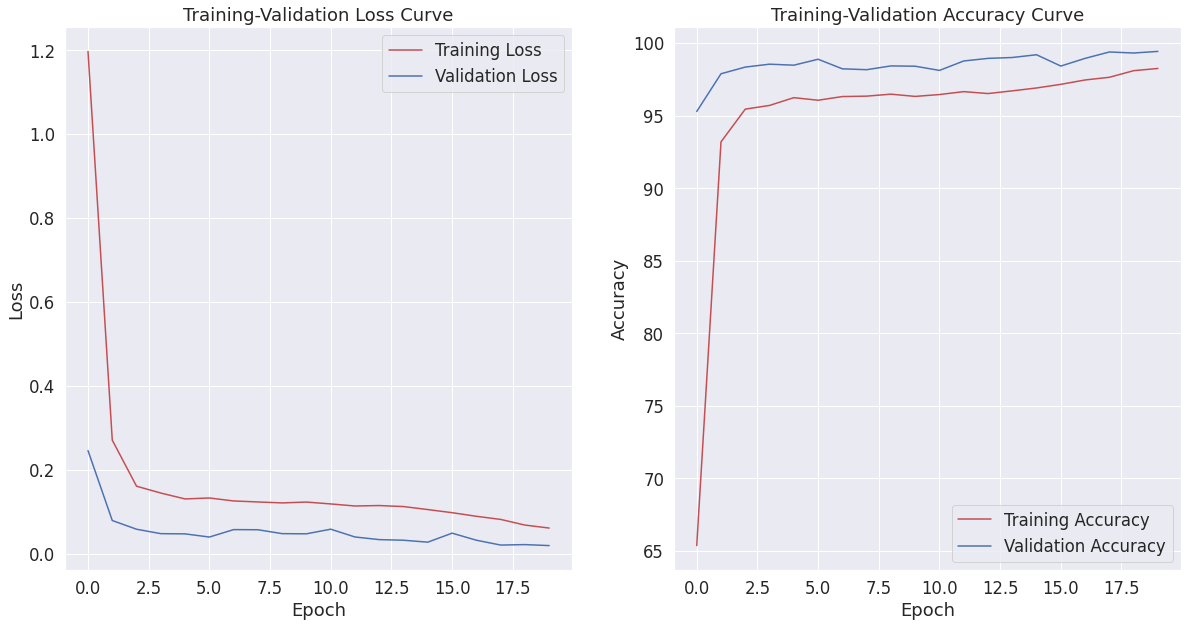

In [ ]:
import numpy as np
import seaborn as sns

sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values), 'r', label="Training Loss")
plt1.plot(np.array(test_loss_values), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy_values), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy_values), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

Number of wrongly predicted images 79


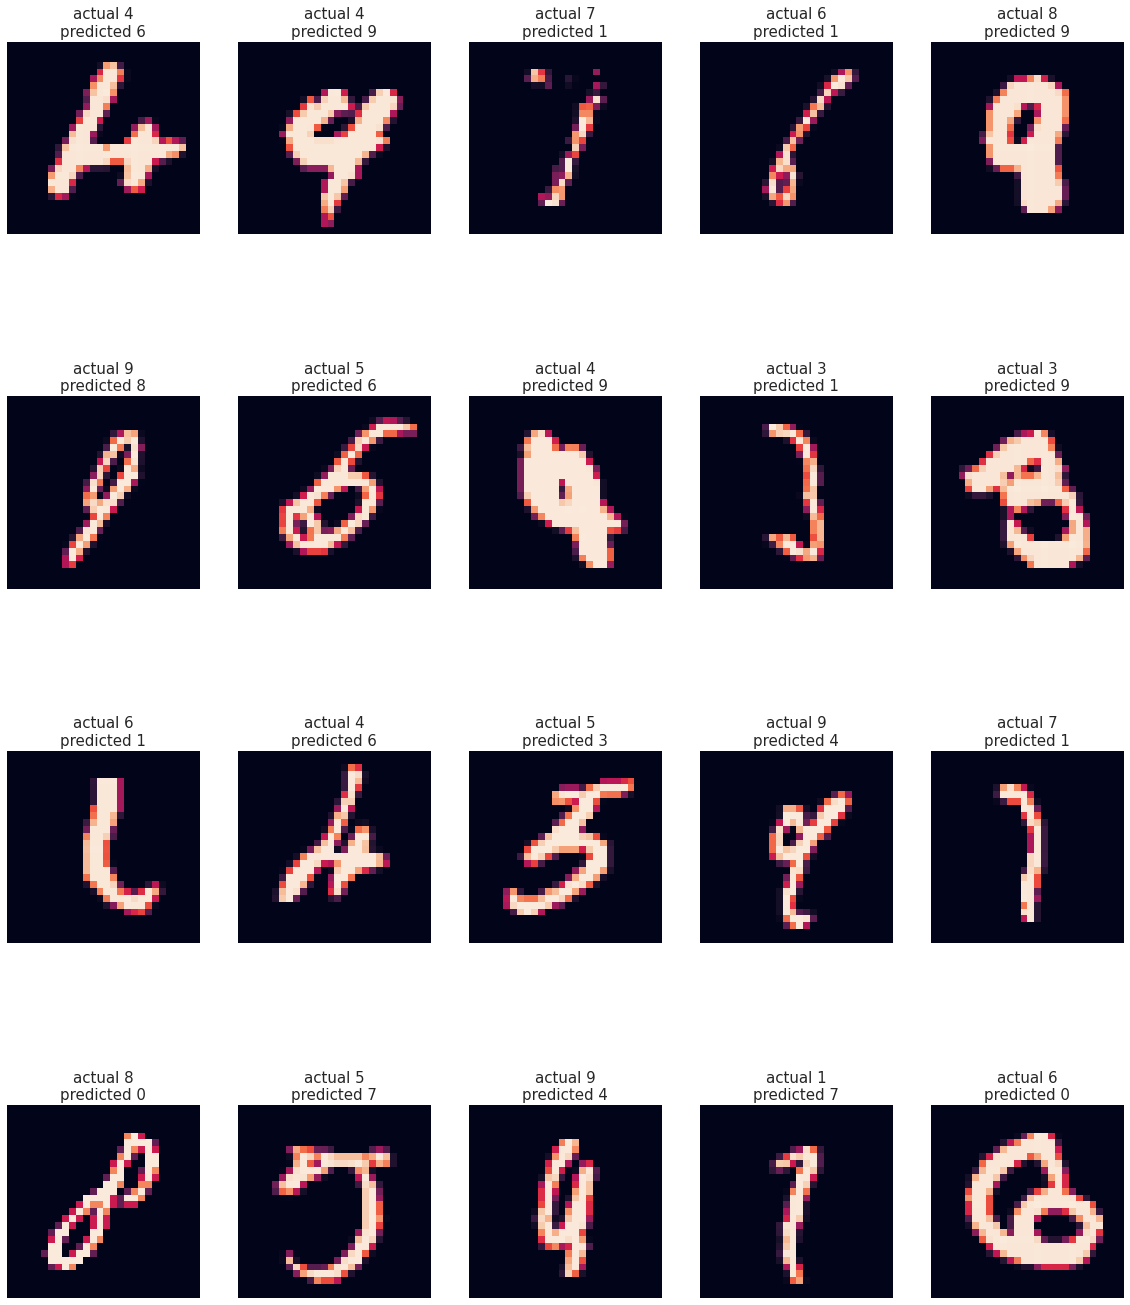

In [ ]:
print(f"Number of wrongly predicted images {len(wrong_images)}")
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(zip(torch.cat(wrong_images),torch.cat(wrong_label), torch.cat(correct_label))):
    if i > 19:
      break
    img = img.cpu().numpy()
    pred = pred.cpu()
    target = correct.cpu()
    ax = fig.add_subplot(4, 5, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())